In [1]:
!nvidia-smi

Wed Apr 21 08:00:39 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   61C    P8    32W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Cotton Leaf Disease Detection


In [2]:
#import libraries
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint

# for accuracy and loss graph
import matplotlib.pyplot as plt

In [3]:
keras.__version__

'2.4.3'

In [4]:
train_data_path = "/content/drive/MyDrive/Data_set/data/train"
validation_data_path = "/content/drive/MyDrive/Data_set/data/val"

In [5]:
# show augmented images
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20, 20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

In [6]:
# this is the augmentation configuration we will use for training
# It generate more images using below parameters
training_datagen = ImageDataGenerator(rescale=1./255,
                                      rotation_range=40,
                                      width_shift_range=0.2,
                                      height_shift_range=0.2,
                                      shear_range=0.2,
                                      zoom_range=0.2,
                                      horizontal_flip=True,
                                      fill_mode='nearest')

# this is a generator that will read pictures found in
# at train_data_path, and indefinitely generate
# batches of augmented image data
training_data = training_datagen.flow_from_directory(train_data_path, # this is the target directory
                                      target_size=(150, 150), # all images will be resized to 150x150
                                      batch_size=32,
                                      class_mode='binary')  # since we use binary_crossentropy loss, we need binary labels

Found 1951 images belonging to 4 classes.


In [7]:
training_data.class_indices

{'diseased cotton leaf': 0,
 'diseased cotton plant': 1,
 'fresh cotton leaf': 2,
 'fresh cotton plant': 3}

In [8]:
# this is the augmentation configuration we will use for validation:
# only rescaling
valid_datagen = ImageDataGenerator(rescale=1./255)

# this is a similar generator, for validation data
valid_data = valid_datagen.flow_from_directory(validation_data_path,
                                  target_size=(150,150),
                                  batch_size=32,
                                  class_mode='binary')

Found 324 images belonging to 4 classes.


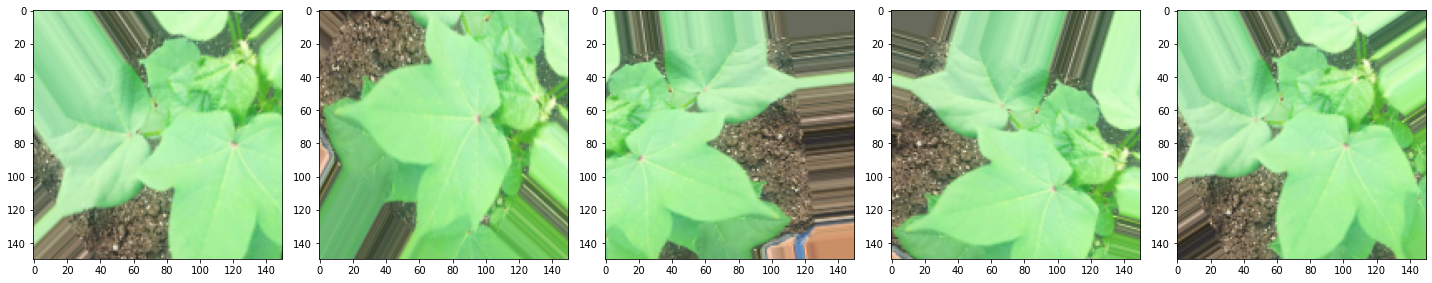

In [9]:
# showing augmented images
images = [training_data[0][0][0] for i in range(5)]
plotImages(images)

In [10]:
# save best model using vall accuracy
model_path = '/content/drive/MyDrive/Data_set/v4_pred_cott_dis.h5'
checkpoint = ModelCheckpoint(model_path, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [11]:
#Building cnn model
cnn_model = keras.models.Sequential([
                                    keras.layers.Conv2D(filters=32, kernel_size=3, input_shape=[150, 150, 3]),
                                    keras.layers.MaxPooling2D(pool_size=(2,2)),
                                    keras.layers.Conv2D(filters=64, kernel_size=3),
                                    keras.layers.MaxPooling2D(pool_size=(2,2)),
                                    keras.layers.Conv2D(filters=128, kernel_size=3),
                                    keras.layers.MaxPooling2D(pool_size=(2,2)),                                    
                                    keras.layers.Conv2D(filters=256, kernel_size=3),
                                    keras.layers.MaxPooling2D(pool_size=(2,2)),

                                    keras.layers.Dropout(0.5),                                                                        
                                    keras.layers.Flatten(), # neural network beulding
                                    keras.layers.Dense(units=128, activation='relu'), # input layers
                                    keras.layers.Dropout(0.1),                                    
                                    keras.layers.Dense(units=256, activation='relu'),                                    
                                    keras.layers.Dropout(0.25),                                    
                                    keras.layers.Dense(units=4, activation='softmax') # output layer
])


# compile cnn model
cnn_model.compile(optimizer = Adam(lr=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [12]:
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 256)       2

In [13]:
# train cnn model
history = cnn_model.fit(training_data, 
                          epochs=100, 
                          verbose=1, 
                          validation_data= valid_data,
                          callbacks=callbacks_list) # time start 16.06

Epoch 1/100
61/61 [==============================] - 1135s 18s/step - loss: 1.3059 - accuracy: 0.3958 - val_loss: 1.2014 - val_accuracy: 0.4475

Epoch 00001: val_accuracy improved from -inf to 0.44753, saving model to /content/drive/MyDrive/Data_set/v4_pred_cott_dis.h5
Epoch 2/100
61/61 [==============================] - 31s 513ms/step - loss: 1.1080 - accuracy: 0.5074 - val_loss: 0.9494 - val_accuracy: 0.5617

Epoch 00002: val_accuracy improved from 0.44753 to 0.56173, saving model to /content/drive/MyDrive/Data_set/v4_pred_cott_dis.h5
Epoch 3/100
61/61 [==============================] - 31s 512ms/step - loss: 0.9982 - accuracy: 0.5862 - val_loss: 0.8911 - val_accuracy: 0.6296

Epoch 00003: val_accuracy improved from 0.56173 to 0.62963, saving model to /content/drive/MyDrive/Data_set/v4_pred_cott_dis.h5
Epoch 4/100
61/61 [==============================] - 31s 513ms/step - loss: 0.8904 - accuracy: 0.6391 - val_loss: 0.7757 - val_accuracy: 0.6883

Epoch 00004: val_accuracy improved from

In [14]:
model_path2 = '/content/drive/MyDrive/Data_set/v4_1_pred_cott_dis.h5'
cnn_model.save(model_path2)

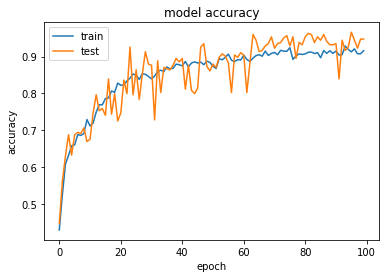

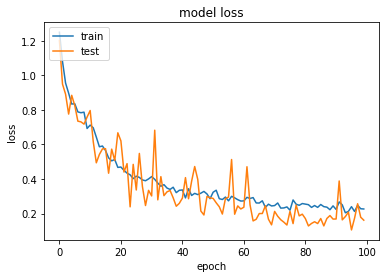

In [15]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()